In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from matplotlib import pyplot

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

In [2]:
draft = pd.read_csv('Compound All Descriptors.csv')
df = draft.iloc[:, 4:]
df['Outcome'] = draft['PUBCHEM_ACTIVITY_OUTCOME']
print(df.columns)
print(len(df))

Index(['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex',
       'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons', 'MaxPartialCharge',
       ...
       'fr_pyridine', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone',
       'fr_tetrazole', 'fr_thiazole', 'fr_thiophene', 'fr_unbrch_alkane',
       'fr_urea', 'Outcome'],
      dtype='object', length=187)
288


In [3]:
df.describe()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_priamide,fr_pyridine,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
count,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,...,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000
mean,12.510201,-2.282583,12.510201,0.097530,0.354673,521.652611,498.402111,520.945014,182.319444,0.347962,...,0.027778,0.135417,0.090278,0.201389,0.038194,0.013889,0.072917,0.034722,0.218750,0.038194
std,1.435861,1.820441,1.435861,0.104690,0.183728,189.612202,183.660090,189.456058,65.713204,0.227276,...,0.164622,0.390295,0.287078,0.458446,0.191999,0.117234,0.273503,0.183394,1.061225,0.209362
min,5.224956,-5.773997,5.224956,0.000000,0.019894,189.993000,184.153000,188.960900,56.000000,0.049711,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.045673,-4.069915,12.045673,0.022092,0.211717,424.299500,401.942750,423.034645,146.000000,0.262294,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.715346,-1.205682,12.715346,0.067676,0.340347,480.227500,458.051500,479.597037,172.000000,0.329327,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13.357796,-0.839154,13.357796,0.135608,0.464693,574.191500,544.843000,573.692393,198.000000,0.341223,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15.181018,0.742450,15.181018,0.742450,0.926723,1634.897000,1529.057000,1633.591520,620.000000,3.000000,...,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,10.000000,2.000000


In [4]:
comdes = df.copy()
pd.value_counts(comdes.Outcome)

Active          114
Inconclusive     93
Inactive         81
Name: Outcome, dtype: int64

In [5]:
# Pick Active and Inactive classes & change to encode
comdes = comdes.loc[comdes['Outcome'] != 'Inconclusive']
comdes['Outcome'] = comdes['Outcome'].replace(['Active', 'Inactive'],[1,0])
comdes

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_pyridine,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,Outcome
0,13.148254,-1.061440,13.148254,0.040675,0.345149,523.630,486.334,523.268236,204,0.339674,...,0,0,0,0,0,0,0,0,0,1
1,12.365894,-0.948790,12.365894,0.011346,0.527665,434.923,411.739,434.139720,158,0.335179,...,0,0,0,0,0,0,0,0,0,1
2,14.718856,-1.627825,14.718856,0.054434,0.228481,628.762,584.410,628.303618,244,0.330444,...,0,0,0,0,0,0,0,0,0,1
3,12.580481,-0.654806,12.580481,0.000075,0.466149,450.619,412.315,450.277010,178,0.308856,...,0,0,0,0,0,0,0,0,0,1
4,12.685953,-0.488708,12.685953,0.023735,0.208777,452.491,436.363,452.083078,160,0.345314,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,10.690205,-1.170865,10.690205,0.211722,0.352410,384.418,364.258,384.121589,142,0.319999,...,0,1,0,0,0,0,0,1,0,0
284,12.509283,-3.800173,12.509283,0.034962,0.101424,640.758,620.598,640.055183,214,0.263161,...,0,0,2,0,0,2,0,0,0,0
285,12.441214,-3.838339,12.441214,0.008609,0.374982,471.926,453.782,471.076803,164,0.262548,...,1,0,1,0,0,0,0,0,0,0
286,14.604270,-0.642009,14.604270,0.003882,0.168894,666.776,652.664,663.926413,206,0.216604,...,0,1,0,0,0,0,0,0,0,0


In [6]:
comdes.astype({'Outcome': 'object'}).dtypes

MaxEStateIndex       float64
MinEStateIndex       float64
MaxAbsEStateIndex    float64
MinAbsEStateIndex    float64
qed                  float64
                      ...   
fr_thiazole            int64
fr_thiophene           int64
fr_unbrch_alkane       int64
fr_urea                int64
Outcome               object
Length: 187, dtype: object

In [7]:
Y = comdes['Outcome']
X = comdes[comdes.columns[:-1]]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

>10 0.743 (0.110)
>50 0.772 (0.089)
>100 0.776 (0.102)
>500 0.777 (0.094)
>1000 0.781 (0.083)


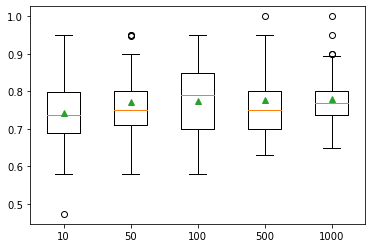

In [8]:
# explore random forest number of trees effect on performance
# get a list of models to evaluate
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [10, 50, 100, 500, 1000]
    for n in n_trees:
        models[str(n)] = RandomForestClassifier(n_estimators=n)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# define dataset
# X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, Y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [9]:
feature_names = [f'feature {i}' for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=43, n_estimators=70)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=70, random_state=43)

In [10]:
from sklearn.metrics import classification_report
predictions = forest.predict(X_test)
print('Classification report for Random Forest')
print(classification_report(y_test, predictions))

Classification report for Random Forest
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        17
           1       0.79      0.86      0.83        22

    accuracy                           0.79        39
   macro avg       0.80      0.78      0.79        39
weighted avg       0.80      0.79      0.79        39



In [11]:
features = np.setdiff1d(X.columns, [Y])
print(features)
# Get the dataframe of feature and importance
df_fi_rfc = pd.DataFrame(np.hstack((features.reshape(-1, 1), forest.feature_importances_.reshape(-1, 1))),
                         columns=['Features', 'Importance'])

# Sort df_fi_rfc in descending order of the importance
df_fi_rfc = df_fi_rfc.sort_values(ascending=False, by='Importance').reset_index(drop=True)

# Print the df_fi_rfc
df_fi_rfc

['BCUT2D_CHGHI' 'BCUT2D_CHGLO' 'BCUT2D_LOGPHI' 'BCUT2D_LOGPLOW'
 'BCUT2D_MRHI' 'BCUT2D_MRLOW' 'BCUT2D_MWHI' 'BCUT2D_MWLOW' 'BalabanJ'
 'BertzCT' 'Chi0' 'Chi0n' 'Chi0v' 'Chi1' 'Chi1n' 'Chi1v' 'Chi2n' 'Chi2v'
 'Chi3n' 'Chi3v' 'Chi4n' 'Chi4v' 'EState_VSA1' 'EState_VSA10'
 'EState_VSA11' 'EState_VSA2' 'EState_VSA3' 'EState_VSA4' 'EState_VSA5'
 'EState_VSA6' 'EState_VSA7' 'EState_VSA8' 'EState_VSA9' 'ExactMolWt'
 'FpDensityMorgan1' 'FpDensityMorgan2' 'FpDensityMorgan3' 'FractionCSP3'
 'HallKierAlpha' 'HeavyAtomCount' 'HeavyAtomMolWt' 'Ipc' 'Kappa1' 'Kappa2'
 'Kappa3' 'LabuteASA' 'MaxAbsEStateIndex' 'MaxAbsPartialCharge'
 'MaxEStateIndex' 'MaxPartialCharge' 'MinAbsEStateIndex'
 'MinAbsPartialCharge' 'MinEStateIndex' 'MinPartialCharge' 'MolLogP'
 'MolMR' 'MolWt' 'NHOHCount' 'NOCount' 'NumAliphaticCarbocycles'
 'NumAliphaticHeterocycles' 'NumAliphaticRings' 'NumAromaticCarbocycles'
 'NumAromaticHeterocycles' 'NumAromaticRings' 'NumHAcceptors' 'NumHDonors'
 'NumHeteroatoms' 'NumRotatableBonds' 

,Features,Importance
0,VSA_EState9,0.054804
1,MolMR,0.040831
2,Chi2v,0.030094
3,PEOE_VSA10,0.025264
4,SlogP_VSA12,0.024827
...,...,...
181,fr_imidazole,0.0
182,fr_Ar_COO,0.0
183,fr_nitrile,0.0
184,VSA_EState7,0.0


In [12]:
df_fi_rfc.to_csv('Random Forest Feature Importance.csv', index=False)

In [13]:
df_fi_rfc.head(50)

,Features,Importance
0,VSA_EState9,0.054804
1,MolMR,0.040831
2,Chi2v,0.030094
3,PEOE_VSA10,0.025264
4,SlogP_VSA12,0.024827
5,NumAliphaticCarbocycles,0.022239
6,NumAromaticHeterocycles,0.021279
7,PEOE_VSA14,0.020892
8,PEOE_VSA2,0.0184
9,SlogP_VSA11,0.016539
